# Path of Exile game stats data eda

dates: 2022.04.30 ~ 

This file contains an analysis processing of the game 'Path of Exile' data.

###### Origins of datas from here: 
poe_stats : https://www.kaggle.com/datasets/gagazet/path-of-exile-league-statistic

Data contains stats of 59000 players, from 4th August of 2017 and before now.

---

This file made for EDA after altering the original data. (about class and rank)

본격적인 EDA로 첫 EDA 주제는 ladder(game mode)에 따라 분석을 진행하였고,

이번 파일에서는 다음 분석으로 '클래스별'로 나누어 볼 예정입니다.


# Dataset and libraries 

## data and libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import wquantiles

from sklearn.utils import resample
from scipy import stats
from scipy.stats import trim_mean
from statsmodels import robust
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

df = pd.read_csv('poe_stats_2revisedrank.csv')

In [2]:
df.head()

,rank,dead,online,name,level,class,id,experience,account,challenges,twitch,ladder,special_class,stat_Str,stat_Int,stat_Dex,stats_num
0,1,False,False,Tzn_NecroIsFineNow,100,Necromancer,3dcddd59f5088893f734f39686350990dae168cc4f4b00...,4250334444,TheTzn,40,thetzn,Harbinger,1,0,1,0,1
1,1,False,False,RaizNeverFirstQT,100,Necromancer,8f3216db5ac9106c287a834731aafc83c387138f28fc45...,4250334444,RaizQT,22,raizqt,SSF Harbinger HC,1,0,1,0,1
2,1,False,False,GucciStreamerAdvantage,100,Necromancer,c6ec2dae3855c551e0597c06ef2da06fbb5512487ded7f...,4250334444,GucciPradas,35,guccipradas,Hardcore Harbinger,1,0,1,0,1
3,1,False,False,ChiroxPrime,100,Slayer,c861372da792be0b22c45bf437ccd58437c52e9455e0bf...,4250334444,Chiroxun,26,NaN,SSF Harbinger,1,1,0,1,2
4,2,False,False,Cool_NecroIsFineNow,100,Deadeye,24ae924ceed7989ef3d3d6772612832bb467a6094352c7...,4250334444,cooltail,22,NaN,Harbinger,1,0,0,1,1


In [3]:
df.shape

(59776, 17)

## data describes

이루어진 컬럼들, 그리고 간단한 통계량 결과 내어놓기

In [4]:
# columns name

df.columns

Index(['rank', 'dead', 'online', 'name', 'level', 'class', 'id', 'experience',
       'account', 'challenges', 'twitch', 'ladder', 'special_class',
       'stat_Str', 'stat_Int', 'stat_Dex', 'stats_num'],
      dtype='object')

In [5]:
df.describe()

,rank,level,experience,challenges,special_class,stat_Str,stat_Int,stat_Dex,stats_num
count,59776.000000,59776.000000,5.977600e+04,59776.000000,59776.000000,59776.000000,59776.000000,59776.000000,59776.000000
mean,7472.536386,85.422578,1.825786e+09,25.759569,0.991702,0.582207,0.418027,0.513450,1.513684
std,4314.060306,11.288017,1.094748e+09,8.440888,0.090713,0.493200,0.493239,0.499823,0.614134
min,1.000000,53.000000,7.790982e+07,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3736.750000,78.000000,7.774697e+08,19.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,7472.500000,90.000000,1.934010e+09,25.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,11208.250000,95.000000,2.876117e+09,33.000000,1.000000,1.000000,1.000000,1.000000,2.000000
max,14981.000000,100.000000,4.250334e+09,40.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [6]:
df.describe(include='object')

,name,class,id,account,twitch,ladder
count,59776,59776,59776,59776,16300,59776
unique,58286,26,59776,37123,9613,4
top,_Flic_,Berserker,3dcddd59f5088893f734f39686350990dae168cc4f4b00...,chuz101,thespunkylobster,SSF Harbinger
freq,14,8711,1,30,18,14981


## describe result understanding (same with previous file)

##### 1. rank
rank가 이루어진 순위는 15000이나 50%에 7472로 있는 것을 볼 수 있다. 

rank의 빈 곳을 일부 채워 넣었기 때문이며, rank max 값 또한 15000이었으나 14981로 수정되어있다.

##### 2. level
이들의 평균 level 은 85이다. 최대 level이 100이지만 대부분 숙련자라는 뜻이며, 이들 중 50%에 해당하는 랭커들이 90레벨 이상이다. 또한 그들 중 25%에 해당하는 사람들이 95레벨 이상이었다. 

*(레벨은 경험이 많은 유저일 수록 레벨이 높고, 그들이 상위 랭크에 올라가있을 확률또한 높으며, 게임이 오래될 수록 신규 유저의 유입은 줄어들어서 전체 유저들의 평균 레벨 자체가 올라가기 때문에 크게 의미를 두지 않을 생각이다.)*

##### 3. exp
경험치는 레벨 자체와 비슷하게 여길 수 있으나 평균이 1.825786e+09, 50%가 1.934010e+09, max값이 4.250334e+09 이다.

그러나 표준편차가 1.094748e+09이다. 가장 작은 값은 7.790982e+07 인데 이와 비교해보기만 해도 상당히 큰 표준편차인 것을 확인할 수 있다.

최소 레벨이 53임을 함께 견주어 볼때, 일반적인 RPG가 그렇듯 레벨이 올라갈 수록 경험치를 더 많이 쌓아야 레벨을 올릴 수 있음을 예상해 볼 수 있는 부분이다. 

##### 4. challenges
도전 횟수로 생각이 된다. 해당 게임 모드를 몇 번을 수행을 했는지에 대한 것으로 생각된다. 적은 사람은 4번이지만 많은 사람은 40번이며,

이 15000등 안에 드는 사람들은 평균적으로 25회 정도 시도한 사람들이었다는 것을 확인할 수 있다.

##### 5. 'special_class', 'stat_Str', 'stat_Int', 'stat_Dex', 'stats_num'
이 부분은 임의로 내가 넣은 부분으로, 클래스를 스탯으로 나누어 쉽게 구분할 수 있도록 만들었다. 

직업 자체도 직업 자체지만, 해당 스킬을 찍기 위해 스탯을 올린다던지, 그렇게 올린 스탯을 더 잘 활용하기 위해 직업을 선택했을 수 있는 부분이 보였기 때문이다.

##### 6. name
비슷한 이름을 쓰는 경우가 많은 가보다. '_Flic_' 이라는 이름이 등장한 것은, 인기있는 이름이었거나 혹은 동일 유저가 많은 계정을 썼을 수도 있다.

확실한 건 이 게임은 같은 닉네임을 허용하는 게임인 것이라는 점이다.

##### 7. class
19개 의 전직 클래스와 7개의 전직 이전 클래스 총 26개가 보인다.

가장 많이 등장한 직업은 스탯 중 힘만 찍는 Marauder 계열의 'Berserker'이고 총 8711 번 등장한다고 한다.

##### 8. id and account
id는 unique 하다. 게임 내에서 캐릭터가 구분되어야 하기 때문일 것이다. 하지만 한 계정이 최대 30번 등장한다. 계정당 만들 수 있는 캐릭터가 제한이 없...나? (게임마다 캐릭터 슬롯을 확장하는 데에 현금을 요구하기도 하기 때문에 이해하지만 30개라니. 다양한 스탯으로 다양한 직업을 할 수 있는 점에서 수긍은 가는 부분.)

30개를 만든 사람은 바로 'chuz101'이라는 유저이다.

재미있는 부분은 6만 여개에 이르는 랭커 순위에서, 사실 unique account, 즉 실제 유저 자체는 6만 여명이 아니라 37123명인 점이다. 

그리고 이 또한 같은 사람이 여러 account를 쓸 가능성도 있기 때문에 실제 랭커는 더욱 줄어들 수 있다. (twitch 아이디로 찾아보면 나오겠지...?)

##### 9. twitch
유일하게 null 값이 있었던 컬럼이다. 실시간 스트리밍을 했는지 안했는지는 모르지만 해당 유저가 자신의 트위치 아이디를 등록을 했는지 안했는지에 따라 나오는 것으로 보인다. 

정확한 사실을 알면 더 좋겠지만, 이 컬럼 자체로 이 사람이 스밍을 하는 트위치 유저였는지 아니면 입력하래서 가지고 있는 트위치 계정을 입력했을 뿐인지는 큰 차이이기 때문에 동일 유저를 판별하는 부분에서만 사용할 수 있을 것으로 생각된다.

위에 계정 개수를 생각했을 때 유니크값이 9613개인 것을 보면 랭커 4명중 1명은 트위치 계정을 갖고있다.

그리고 총 16300 레코드가 기록되어 있으므로 같은 유저의 다 계정이 확실시 되는 부분이다.

'thespunkylobster' 라고 성급한 바닷가재라는 사람이 총 18번 등장했다고 한다.

##### 10. ladder
이전에 자세히 다루었던 부분이지만, 이 데이터를 크게 구분짓는 줄기라고 생각된다. 왜냐하면 게임모드이고, 게임모드의 난이도나 파티플레이 가능 여부는 게임 플레이에서 큰 영향을 끼친다.

숙련되지 않은 사람을 버스태울(!)수도 있고, 클래스별로 분포도 갈릴 것이다. 이후 자세히 볼 예정이다.

---

*분석의 목적을 정확히 정하고 싶지만 이 게임에서 랭킹에 드는 기준조차 제대로 모르기 때문에, 랭커들의 직업이나 특성들을 찾아보는 것을 주 목적으로 하되, 데이터로 게임(맥락)을 이해할 수 있을지 궁금한 부분도 있어서 최대한 많은 생각을 하면서 분석을 진행하려 한다.*

In [7]:
df.nunique()

rank             14981
dead                 2
online               2
name             58286
level               48
class               26
id               59776
experience       54124
account          37123
challenges          37
twitch            9613
ladder               4
special_class        2
stat_Str             2
stat_Int             2
stat_Dex             2
stats_num            3
dtype: int64

In [8]:
df.isnull().sum()

rank                 0
dead                 0
online               0
name                 0
level                0
class                0
id                   0
experience           0
account              0
challenges           0
twitch           43476
ladder               0
special_class        0
stat_Str             0
stat_Int             0
stat_Dex             0
stats_num            0
dtype: int64

## 전처리1: Drop columns

본 파일에서는 클래스를 중심으로 레벨, 경험치, 죽음이나, 시도 횟수 등을 볼 것이기 때문에 name과 account, twitch는 제거하도록 할 것이다. 

유저와 관련한 상세한 데이터분석은 다른 파일에서 진행할 것!

다른 것들은 겹칠 수 있어서 고유 값이 필요하므로 id는 남겨두기로 한다.

In [9]:
df.drop(columns = ['name', 'account', 'twitch'], inplace = True)

# Division with 'class' in this file

## class divising conditions

```
각 클래스 나누기 (전직하지 않은 사람들도 있기 때문에 각 전직 이전 직업도 넣어준다.)

# 한 개인 직업
Marauder = ['Marauder', 'Juggernaut', 'Berserker', 'Chieftain'] # Strength
Witch = ['Witch', 'Necromancer', 'Elementalist', 'Occultist'] # Intelligence
Ranger = ['Ranger', 'Raider', 'Deadeye', 'Pathfinder'] # Dexterity

# 두 개인 직업
Duelist = ['Duelist', 'Slayer', 'Gladiator', 'Champion'] # Strength, Dexterity
Shadow = ['Shadow', 'Assassin', 'Saboteur', 'Trickster'] # Dexterity, Intelligence
Templar = ['Templar', 'Inquisitor', 'Hierophant', 'Guardian'] # Intelligence, Strength

# 세 개인 직업
Scion = ['Scion', 'Ascendant'] # Strength, Dexterity, Intelligence
```

In [10]:
"""
이후 데이터를 조금 쉽게 활용하기 위해 나누었던 컬럼을 사용할 부분을 적어둔다.
"""

# 전직을 선택하지 않은 직업
con_pre_classes = df['special_class'] == 0

# 각 스탯을 찍은 상태
con_str = df['stat_Str'] == 1
con_int = df['stat_Int'] == 1
con_dex = df['stat_Dex'] == 1

In [11]:
# condition 확인용 Marauder

df[con_str & ~con_int & ~con_dex]['class'].unique()

array(['Chieftain', 'Berserker', 'Juggernaut', 'Marauder'], dtype=object)

# how much is each stats about 

## Only one stats

고유한 id는 지웠으나 rank는 

In [12]:
# 힘에 올인한 랭커유저는 전체랭커 중 얼마나 될까?

print("Marauders(Only Strenth characters) rate :")
print(df[con_str & ~con_int & ~con_dex]['id'].count()/df['id'].count() * 100)

Marauders(Only Strenth characters) rate :
21.69097965738758


In [13]:
# 민첩에 올인한 랭커유저는 전체랭커 중 얼마나 될까?

print("Rangers(Only Dexterity characters) rate :")
print(df[~con_str & ~con_int & con_dex]['id'].count()/df['id'].count() * 100)

Rangers(Only Dexterity characters) rate :
16.99009635974304


In [14]:
# 지능에 올인한 랭커유저는 전체랭커 중 얼마나 될까?

print("Witches(Only Intellegence characters) rate :")
print(df[~con_str & con_int & ~con_dex]['id'].count()/df['id'].count() * 100)

Witches(Only Intellegence characters) rate :
16.317585653104924


## Two stats

In [15]:
# 힘과 민첩을 올린 랭커유저는 전체랭커 중 얼마나 될까?

print("Duelists(Strenth and Dexterity stats characters) rate :")
print(df[con_str & ~con_int & con_dex]['id'].count()/df['id'].count() * 100)

Duelists(Strenth and Dexterity stats characters) rate :
19.516193790149895


In [16]:
# 민첩과 지능을 올린 랭커유저는 전체랭커 중 얼마나 될까?

print("Shadows(Dexterity and Intellegence stats characters) rate :")
print(df[~con_str & con_int & con_dex]['id'].count()/df['id'].count() * 100)

Shadows(Dexterity and Intellegence stats characters) rate :
8.471627408993577


In [17]:
# 지능과 힘을 올린 랭커유저는 전체랭커 중 얼마나 될까?

print("Templars(Intellegence and Strenth stats characters) rate :")
print(df[con_str & con_int & ~con_dex]['id'].count()/df['id'].count() * 100)

Templars(Intellegence and Strenth stats characters) rate :
10.646413276231263


## Thre stats - Scions

In [18]:
# 세 스탯을 골고루 하길 원한 랭커유저는 전체랭커 중 얼마나 될까?

print("Scions(all three stats characters) rate :")
print(df[df['stats_num'] == 3]['id'].count()/df['id'].count() * 100)

Scions(all three stats characters) rate :
6.367103854389722


## 전처리2: 분석의 편의상 라벨링을 해야할 필요성을 느껴서 진행

In [19]:
# 분석상 편의를 위해 직업군 라벨링을 해야하는 상황이 와서 컬럼을 만들기로 했다.

# 한 개인 직업
Marauder = ['Marauder', 'Juggernaut', 'Berserker', 'Chieftain'] # Strength
Witch = ['Witch', 'Necromancer', 'Elementalist', 'Occultist'] # Intelligence
Ranger = ['Ranger', 'Raider', 'Deadeye', 'Pathfinder'] # Dexterity

# 두 개인 직업
Duelist = ['Duelist', 'Slayer', 'Gladiator', 'Champion'] # Strength, Dexterity
Shadow = ['Shadow', 'Assassin', 'Saboteur', 'Trickster'] # Dexterity, Intelligence
Templar = ['Templar', 'Inquisitor', 'Hierophant', 'Guardian'] # Intelligence, Strength

# 세 개인 직업
Scion = ['Scion', 'Ascendant'] # Strength, Dexterity, Intelligence

In [20]:
df['pre_class'] = '1'
conditionlist = [
    (con_str & ~con_int & ~con_dex),
    (~con_str & con_int & ~con_dex),
    (~con_str & ~con_int & con_dex),
    (con_str & ~con_int & con_dex),
    (~con_str & con_int & con_dex),
    (con_str & con_int & ~con_dex),
    (con_str & con_int & con_dex)]
choicelist = ['M', 'W', 'R', 'D', 'S', 'T', 'Sc']
df['pre_class'] = np.select(conditionlist, choicelist, default='Not Specified')

In [21]:
df['pre_class'].unique()

array(['W', 'D', 'R', 'T', 'M', 'Sc', 'S'], dtype=object)

In [23]:
df.sample(5)

,rank,dead,online,level,class,id,experience,challenges,ladder,special_class,stat_Str,stat_Int,stat_Dex,stats_num,pre_class
48427,12084,False,False,95,Berserker,8568276ac62051820eac670dcd844ca52727be3bd4e1eb...,2876162042,39,Harbinger,1,1,0,0,1,M
29553,7373,False,False,95,Pathfinder,b29da218a7bca481e38f011013de8072673b4931247ec8...,2932389081,38,Harbinger,1,0,0,1,1,R
17562,4400,False,False,87,Necromancer,16cc92bee27dc815a681fe5caf5d9ad28c767b747c437c...,1552638795,22,SSF Harbinger,1,0,1,0,1,W
41166,10311,True,False,66,Ascendant,a8b3de50e36551d21281a1b0cfc63813f84f304693fc61...,255501412,18,SSF Harbinger HC,1,1,1,1,3,Sc
10354,2593,True,False,84,Necromancer,4e1f79a04ace48814c1e536a1c7420a8c7e9188139a796...,1208620399,36,SSF Harbinger HC,1,0,1,0,1,W


# preference of stats - 시각화

> 전체적으로 세 스텟 중 가장 선호되는 능력은?

In [22]:
# 각 스캣을 그대로 카운트 하기 위해 데려옴

df_stats = df[['stat_Str','stat_Dex', 'stat_Int']]

<AxesSubplot:>

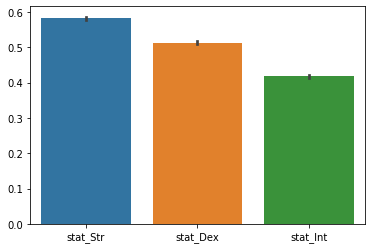

In [23]:
sns.barplot(data= df_stats)

힘인 것으로 나타났다.

## preference of classes by pre_class, by stats_num 시각화

그렇다면 직업별 선호도는 어떻게 될까?

<AxesSubplot:xlabel='pre_class', ylabel='Count'>

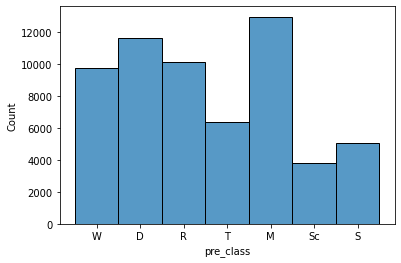

In [24]:
sns.histplot(data=df, x = 'pre_class')

## preference of stats number 시각화

직업자체보다 몇 가지를 찍는 것에 대해 더 중요하게 생각하는 경우는 이런 그래프를 그릴 수 있을 것이다.

<AxesSubplot:xlabel='stats_num', ylabel='Count'>

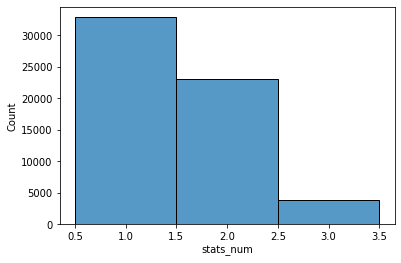

In [25]:
sns.histplot(data = df, x = 'stats_num', fill = True, discrete = True) 

# discrete = True/ False 옵션은 이산형인지를 따지는 것으로, 딱 이런 경우에 필요한 옵션이다.

## Commentary

1. 전체적으로 스탯을 살펴보았을 때, 힘을 찍은 캐릭터들이 가장 많았다.

2. 전체 직업별 캐릭터수를 본다면 Marauder가 가장 많은 수를 기록했고 그 다음은 Dualist, Ranger 순이었다. Scion과 Shadow가 차례로 가장 적은 수를 보였다.

3. 또한 스탯 조합을 한 가지 스탯만 찍은 사람이 가장 적었다.

전체 게임 모드에서 직업별 %는 다음과 같다. (:.2f)

```
Marauders(Only Strenth characters) rate : 21.69
Rangers(Only Dexterity characters) rate : 16.99
Witches(Only Intellegence characters) rate : 16.32
Duelists(Strenth and Dexterity stats characters) rate : 19.52
Shadows(Dexterity and Intellegence stats characters) rate : 8.47
Templars(Intellegence and Strenth stats characters) rate : 10.65
Scions(all three stats characters) rate : 6.37
```

# level, rank

## means of rank and level

> 이미 이들은 충분히 상위 랭크이지만, 그 중에서도 직업에 따라 더 높은 랭크가 있지않을까?

> 직업군에 따라 그들의 레벨도 차이가 있지 않을까?

순위이기 때문에 중간값 자체를 평균을 대체할 수 있는 값으로 생각하여 함께 넣었다.

In [26]:
# 중간값

df.pivot_table(index = ['stat_Str','stat_Dex', 'stat_Int'], aggfunc = 'median')

challenges  dead    experience  level  online  \
stat_Str stat_Dex stat_Int                                                  
0        0        1                 24   0.0  1.692471e+09     88     0.0   
         1        0                 29   0.0  2.853477e+09     94     0.0   
                  1                 24   0.0  1.400795e+09     86     0.0   
1        0        0                 25   0.0  1.934010e+09     90     0.0   
                  1                 24   0.0  1.799050e+09     89     0.0   
         1        0                 25   0.0  1.927951e+09     89     0.0   
                  1                 25   0.0  1.905394e+09     89     0.0   

                              rank  special_class  stats_num  
stat_Str stat_Dex stat_Int                                    
0        0        1         7397.5              1          1  
         1        0         7355.0              1          1  
                  1         7836.5              1          2  
1        0        0         7551.0              1          1  
                  1         7771.0              1          2  
         1        0         7160.5              1          2  
                  1         7707.5              1          3

In [27]:
# 평균

df.pivot_table(index = ['stat_Str','stat_Dex', 'stat_Int'], aggfunc = 'mean')

challenges      dead    experience      level  \
stat_Str stat_Dex stat_Int                                                  
0        0        1          24.463092  0.384970  1.635681e+09  83.540086   
         1        0          29.120618  0.185112  2.348853e+09  89.500492   
                  1          24.036335  0.398499  1.452039e+09  82.181280   
1        0        0          25.627025  0.345133  1.828874e+09  85.758445   
                  1          24.641263  0.402420  1.648498e+09  83.678190   
         1        0          25.348191  0.384022  1.804477e+09  85.561203   
                  1          25.988702  0.370993  1.765743e+09  85.025749   

                              online         rank  special_class  stats_num  
stat_Str stat_Dex stat_Int                                                   
0        0        1         0.013328  7445.416650       0.987800          1  
         1        0         0.030032  7382.341375       0.995274          1  
                  1         0.007504  7686.580964       0.990916          2  
1        0        0         0.012109  7549.249807       0.992673          1  
                  1         0.008014  7627.751571       0.988843          2  
         1        0         0.012001  7276.447968       0.994428          2  
                  1         0.013137  7578.089858       0.986337          3

### Commentary

*랭크는 낮을수록, 레벨은 높을 수록!*

이미 이들은 충분히 상위 랭크이지만, 그 중에서도 더 높은 랭크가 있지않을까?

> 랭크는 순위개념이라 중간값을 보았을 때, 상대적으로 랭크가 조금더 높은 사람들은 Str+Dex조합(듀얼리스트)이나 Dex만 찍은 직업군(레인저)인 경우가 많았다.

> 물론 직업군간의 인원 차이도 고려를 하고 계산을 해본다면 비슷해질 수도 있을 것 같다는 생각이다.

직업군에 따라 그들의 레벨도 차이가 있지 않을까?

> 직업군에 따라 레벨차이는 많이 나지는 않았으나 상대적으로 Dex만 찍은 직업군이 평균 레벨이 높은 편이었고,

> Dex+Int 조합이나 Int만, 혹은 Str+Int 조합이 평균 레벨이 상대적으로 낮았다.

---

또한 아래처럼 pre_class를 구한 것으로 볼수도 있다. 

### medians of rank and level with class name

In [28]:
df.pivot_table(index = 'pre_class', aggfunc = 'median')

,challenges,dead,experience,level,online,rank,special_class,stat_Dex,stat_Int,stat_Str,stats_num
pre_class,,,,,,,,,,,
D,25,0.0,1.927951e+09,89,0.0,7160.5,1,1,0,1,2
M,25,0.0,1.934010e+09,90,0.0,7551.0,1,0,0,1,1
R,29,0.0,2.853477e+09,94,0.0,7355.0,1,1,0,0,1
S,24,0.0,1.400795e+09,86,0.0,7836.5,1,1,1,0,2
Sc,25,0.0,1.905394e+09,89,0.0,7707.5,1,1,1,1,3
T,24,0.0,1.799050e+09,89,0.0,7771.0,1,0,1,1,2
W,24,0.0,1.692471e+09,88,0.0,7397.5,1,0,1,0,1


## Level distribution - violinplot

각각 유저들의 수가 차이가 나기 때문에 이렇게 보도록 한다.

<AxesSubplot:xlabel='pre_class', ylabel='level'>

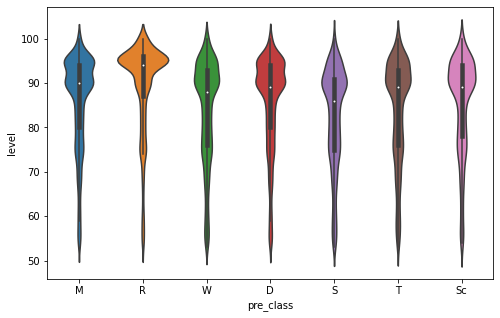

In [29]:
# 전체 직업 함께 비교

plt.rcParams["figure.figsize"] = (8, 5)
sns.violinplot(data = df, x = 'pre_class', y = 'level', order = ['M', 'R', 'W', 'D', 'S', 'T', 'Sc'])

<AxesSubplot:xlabel='pre_class', ylabel='level'>

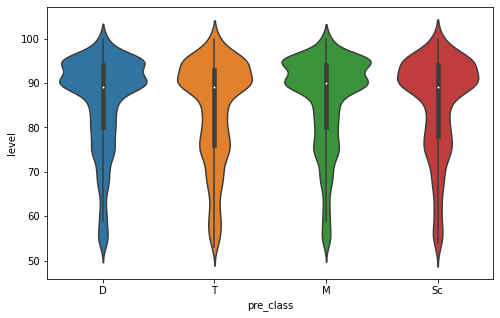

In [30]:
# 힘을 찍은 직업군의 비교

# plt.rcParams["figure.figsize"] = (8, 5)
sns.violinplot(data = df[df['stat_Str'] == 1], x = 'pre_class', y = 'level')

<AxesSubplot:xlabel='pre_class', ylabel='level'>

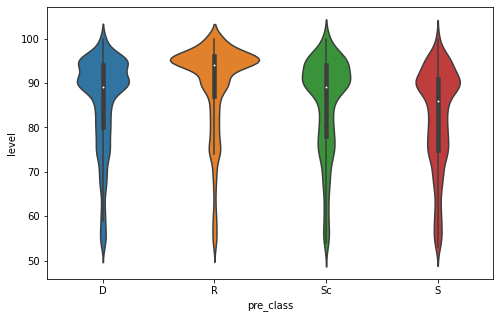

In [31]:
# 민첩을 찍은 직업군의 비교

# plt.rcParams["figure.figsize"] = (8, 5)
sns.violinplot(data = df[df['stat_Dex'] == 1], x = 'pre_class', y = 'level')

<AxesSubplot:xlabel='pre_class', ylabel='level'>

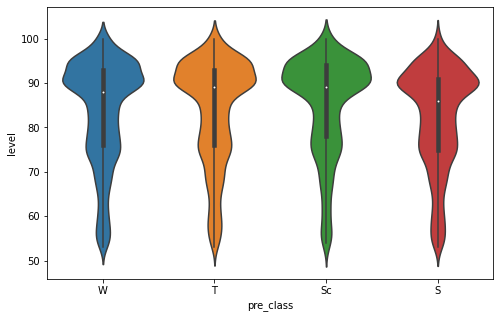

In [32]:
# 지능을 찍은 직업군의 비교

# plt.rcParams["figure.figsize"] = (8, 5)
sns.violinplot(data = df[df['stat_Int'] == 1], x = 'pre_class', y = 'level')

### Commentary

레벨별 분포를 보면 우선 전부 50레벨 이상인것을 알아야 한다. 이들은 충분한 숙련도가 있는 사람들이라는 전제가 있다.

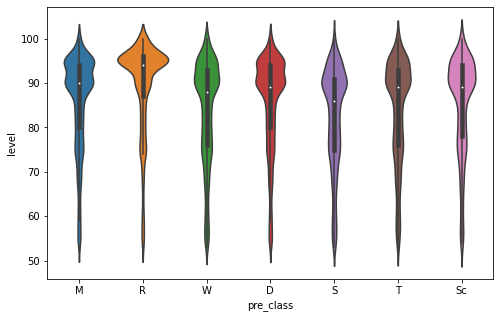

이것을 보면 유독 Ranger(민첩만 찍은) 직업군이 좀더 높은 레벨에서 많은 수를 보이고 있다는 것을 알 수 있다.

실제로 민첩을 찍은 다른 직업군들과도 비교가 되는데, ranger의 많은 유저가 95레벨 정도의 고레벨에 많이 분포하는 것으로 나타났다.

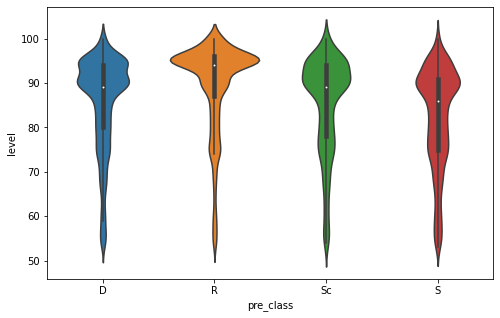

## Rank distribution 

<AxesSubplot:xlabel='pre_class', ylabel='rank'>

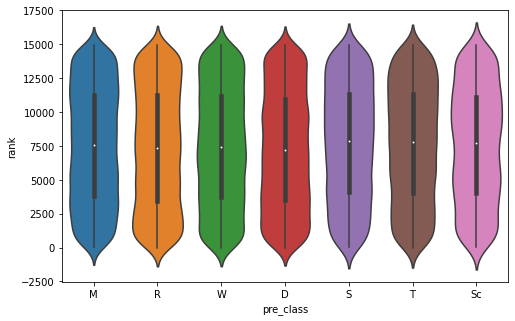

In [33]:
# 우선 바이을린 플롯을 그려본다.
# 전체 직업 함께 비교

# plt.rcParams["figure.figsize"] = (8, 5)
sns.violinplot(data = df, x = 'pre_class', y = 'rank', order = ['M', 'R', 'W', 'D', 'S', 'T', 'Sc'])

*그럴줄알았어....*

바이올린 플롯은 해당 분포를 적절하게 보여줄 수 있는 그래프가 아니며, 보여줄 수 있는 그래프가 무엇이 있을까 고민해보았지만 아직 내 실력에는 없었다고 한다.

라인플롯도 무쓸모(?) 이고 결국 사용한건 바플롯이었다.

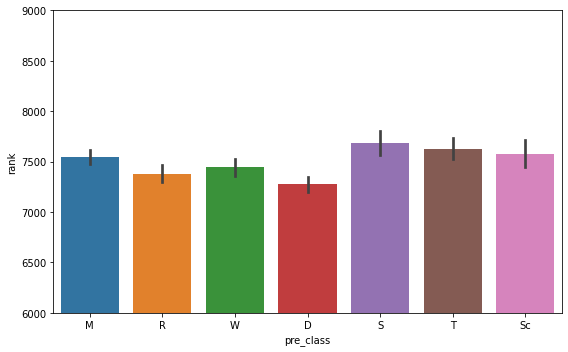

In [42]:
# 평균 랭크 

plt.subplots(figsize = (8, 5))

plt.xlabel('Class name')
plt.ylabel('Means of Rank')
plt.ylim(bottom = 6000, top = 9000)

sns.barplot(x = 'pre_class', y = 'rank', data = df, order = ['M', 'R', 'W', 'D', 'S', 'T', 'Sc'])

plt.tight_layout()
plt.show()

왜째서 label은 출력이 안되세요?
### Comentary
전체적으로 보았을 때 평균 랭크는 비슷비슷했다. Dualist 가 가장 높은 Shadow보다 대략 500위 정도 더 높아보인다.

## level 과 rank에 선형관계가 있는가?

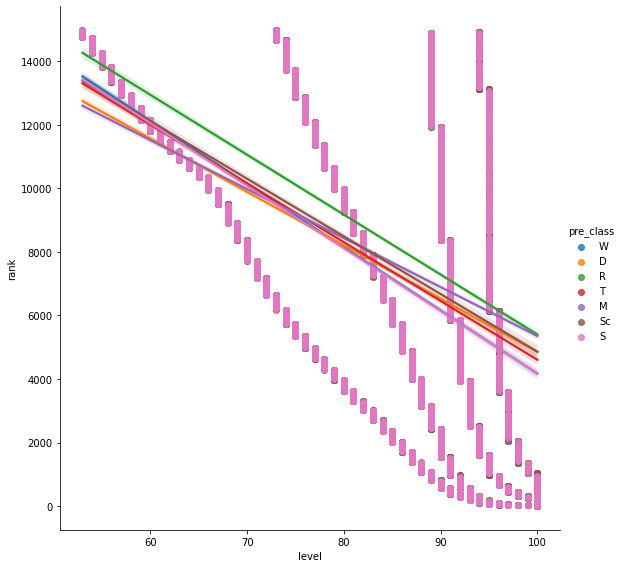

In [43]:
# 선형관계를 보기위한 lmplot

sns.lmplot(x = 'level', y = 'rank', hue = 'pre_class', height = 8, data = df)
plt.show()

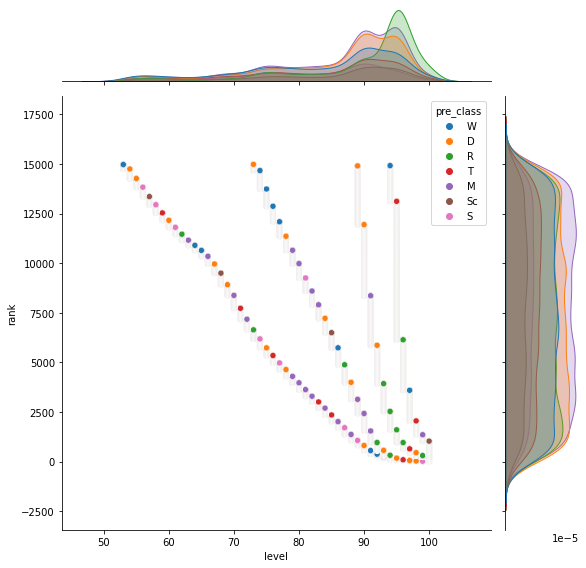

In [44]:
# 산점도와 히스토그램을 동시에 본다.

sns.jointplot(x = 'level', y = 'rank', hue = 'pre_class' ,height = 8, data = df)
plt.show()

*뭐지 이 괴랄한 그림들은*

## Commentary

하지만 대체적으로 음의 상관관계를 보여줬다. 랭크는 낮을 수록 좋은 것이므로,

간단히 해석하자면 약 6만개의 캐릭터 안에서도 상위 랭킹의 캐릭들은 실제로 레벨도 높은 편이라는 것을 알 수 있다.

게임 모드를 나누면 조금더 정확히 나올 것이다. (랭크를 고유한 값을 가질 것이므로)


### level과 rank와 음의 선형관계를 ladder 별로 세분화.

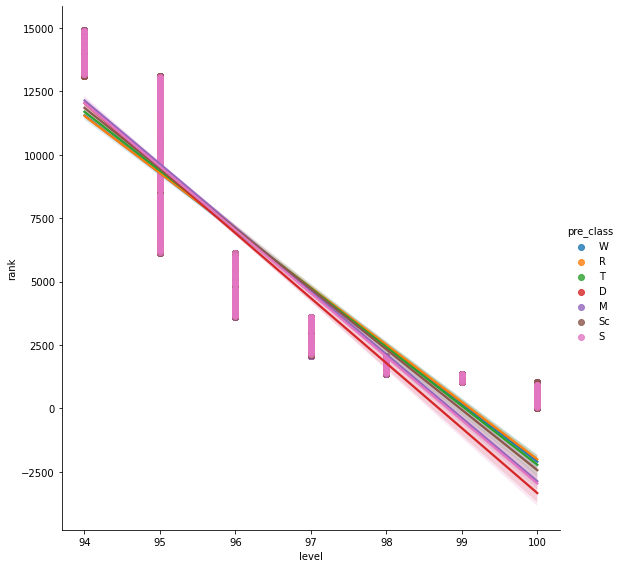

In [45]:
# 선형관계를 보기위한 lmplot

sns.lmplot(x = 'level', y = 'rank', hue = 'pre_class', height = 8, data = df[df['ladder'] == 'Harbinger'])
plt.show()

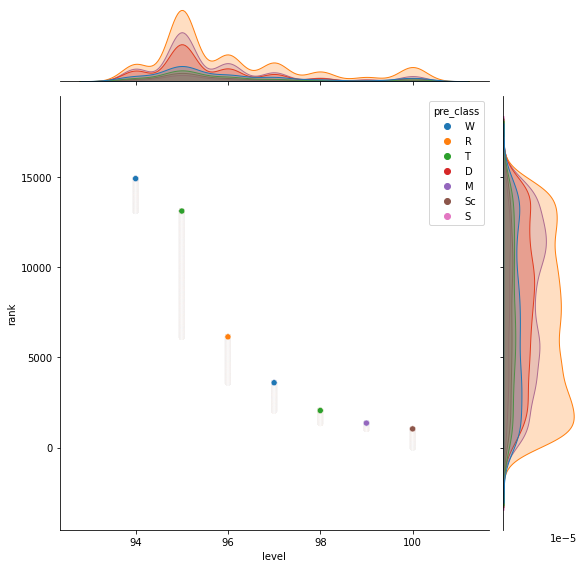

In [46]:
# 산점도와 히스토그램을 동시에 본다.

sns.jointplot(x = 'level', y = 'rank', hue = 'pre_class' ,height = 8, data = df[df['ladder'] == 'Harbinger'])
plt.show()

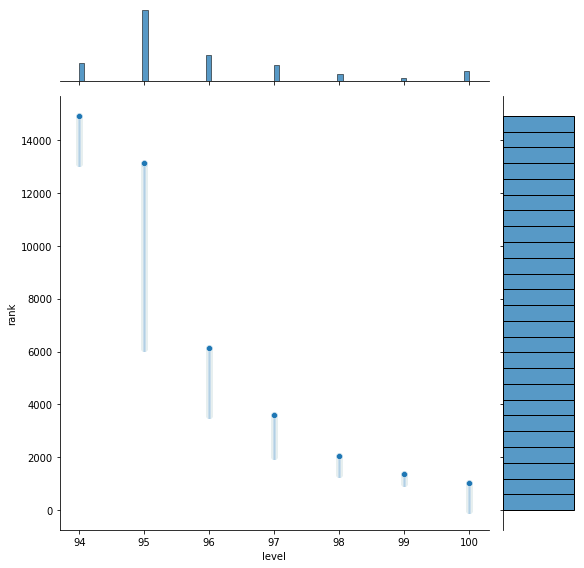

In [47]:
# 직업 분리를 제거하고 보겠다.

sns.jointplot(x = 'level', y = 'rank' , height = 8, data = df[df['ladder'] == 'Harbinger'])
plt.show()

### Comentary

아무래도 이부분은 클래스를 좀더 나누어보는게 낫다는 생각.

으로 아래 테스트. (하지만 나누어 보아도 이해는 쉽지 않겠다는 생각. 잘 표현되지 않는다.)

<AxesSubplot:xlabel='level', ylabel='rank'>

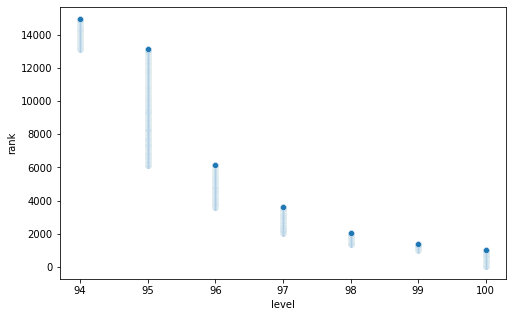

In [58]:
sns.scatterplot(x = 'level', y = 'rank', data = df[(df['ladder'] == 'Harbinger')&(df['pre_class'] == 'M')])

# ladder
---
클래스별로 특정 래더에서 더 좋은 성능을 낼 수도 있지 않을까?

그럼 클래스별로 어느 래더에 더 분포되어있는지 볼 수 있을 것이다.

## class-ladder

<AxesSubplot:xlabel='pre_class', ylabel='Count'>

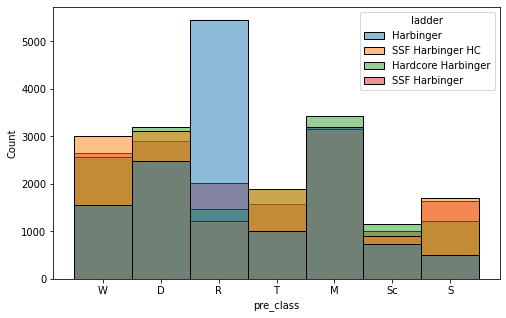

In [48]:
sns.histplot( x = 'pre_class', hue = 'ladder', data = df)

재미있는 결과가 나왔다. 전체적으로는 Marauder가 많은 수를 차지하고 있긴 했지만, Ranger 직업군이 Harbinger 기본모드에 많이 분포되어있는 것으로 나타났다. 

그러나 그래프가 내가 보기원하는 것을 잘 보여주는 것 같지는 않아서 다시 그려보기로 했다.

<AxesSubplot:xlabel='pre_class', ylabel='Count'>

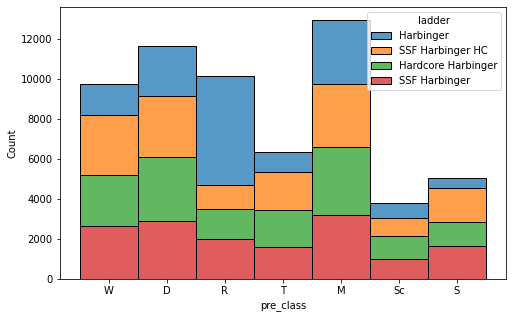

In [49]:
sns.histplot(x = 'pre_class', hue = 'ladder', data = df, multiple = 'stack')

총 직업군 숫자에 맞게 잘 나온 것 같다. 클래스 별로 어떤 모드에서 더 많이 사용되는 것이 있을 텐데, 전체적으로는 Marauder 가 선호되는 편이지만

각 모드에서 Marauder 더 선호되는 클래스가 분명 있을 것이기 때문이다. 그를 보기위해 보는 모드를 달리해본다.

<AxesSubplot:xlabel='pre_class', ylabel='Count'>

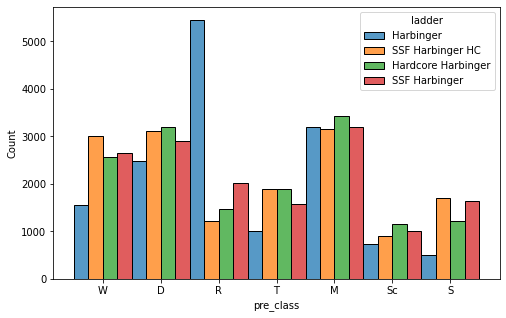

In [51]:
sns.histplot(x = 'pre_class', hue = 'ladder', data = df, multiple = 'dodge')

좀 띄워줄래?

<AxesSubplot:xlabel='pre_class', ylabel='count'>

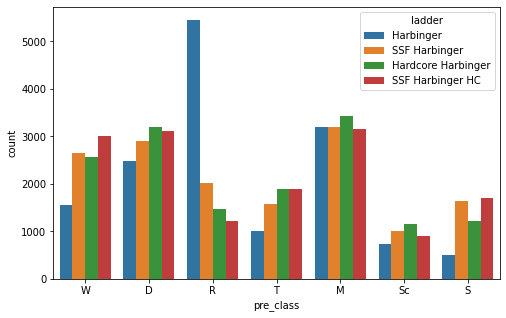

In [52]:
sns.countplot(x = 'pre_class', hue = 'ladder', data = df, hue_order = ['Harbinger', 'SSF Harbinger', 'Hardcore Harbinger', 'SSF Harbinger HC'])

## one stat class 만 모아본다면

<AxesSubplot:xlabel='pre_class', ylabel='count'>

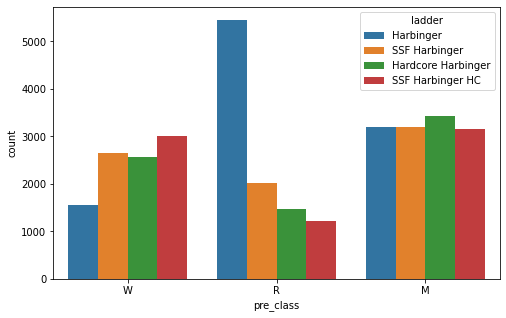

In [53]:
sns.countplot(data = df[df['stats_num'] == 1], x = 'pre_class', hue = 'ladder', hue_order = ['Harbinger', 'SSF Harbinger', 'Hardcore Harbinger', 'SSF Harbinger HC'])

### class-ladder Commentary

특정 모드별로 선호되는 클래스 즉, 클래스별로 어떤 모드에서 더 선호될 수도 있겠다는 생각을 했는데, 

**실제로 Ranger 직업군이 Harbinger에서 눈에띄게 선호됨을 볼 수 있다.**

전체적으로 했을 때는 Marauder가 가장 선호되었지만, Harbinger 모드에서 유독 Ranger가 선호되었다. 

##### 해석해보자면,

Harbinger모드는 솔로모드가 아니기 때문에 Ranger가 가지지 않은 다른 스킬들을 다른 사람이 채워줄 수 있다. 

한 가지 주목할 점은 Ranger는 민첩만 찍는 직업군으로, 그렇다면 어느 스탯이나 똑같이 채워주는 사람이 있다는 전제하에 좋은 성능을 보여주는 직업군으로 생각해 볼 수 있다.

다시 말해, 똑같이 한 스탯에 point를 올인을 한다고 했을 때 그 스탯의 장점을 잘 살려서 좋은 성능을 보여주는 것은 민첩이 아닐까 생각이 된다.

반대로 말하면 일정 수준 이상 많은 집중을 하지 않으면 성능이 덜 나올 수도 있거나, 누군가 보조해주지 않으면 성능을 받쳐주기 어렵다는 생각도 해볼 수 있다. 

왜냐면, 똑같이 한 스탯(힘)에 집중하는 Marauder 는 약 15000명을 모아둔 각 모드에서 비슷한 분포를 가지고 있었기 때문이다.

또한 Witch도 지능 한 스탯에 집중하는 직업군인데, 파티모드보다 다른 모드에서 더 많이 쓰였으며, 똑같이 HC가 아닌 솔로 Harbinger모드에서는 거의 1.7배에 가까운 캐릭터가 존재하고 있었다. 

그리고 Templar 같은 직업은 SSF아닌 모드에서 전체적으로 선호되지 않을까 했지만 그 예상또한 빗나갔다.

한 스탯만 찍은 캐릭터들, 이 셋만 두고 비교를 해본다면?

# Number of stat

---

# one stat class

스탯 개수별로 분석을 시작해보자. 

우선 한 스탯만 찍은 캐릭터들이다.

In [55]:
df[df['stats_num'] == 1].describe()

,rank,level,experience,challenges,special_class,stat_Str,stat_Int,stat_Dex,stats_num
count,32876.000000,32876.000000,3.287600e+04,32876.000000,32876.000000,32876.000000,32876.000000,32876.000000,32876.0
mean,7466.882407,86.256266,1.932187e+09,26.360932,0.992031,0.394391,0.296691,0.308918,1.0
std,4329.881821,11.205555,1.120851e+09,8.576560,0.088916,0.488727,0.456806,0.462054,0.0
min,1.000000,53.000000,7.790982e+07,4.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,3705.750000,80.000000,8.594550e+08,20.000000,1.000000,0.000000,0.000000,0.000000,1.0
50%,7448.500000,90.000000,1.983722e+09,26.000000,1.000000,0.000000,0.000000,0.000000,1.0
75%,11250.250000,95.000000,2.878193e+09,35.000000,1.000000,1.000000,1.000000,1.000000,1.0
max,14978.000000,100.000000,4.250334e+09,40.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [56]:
# 전체 중 스탯 하나만 찍은 캐릭터들

df[df['stats_num'] == 1]['pre_class'].value_counts() / df.shape[0] * 100

M    21.690980
R    16.990096
W    16.317586
Name: pre_class, dtype: float64

In [57]:
# 스탯 하나만 찍은 캐릭터들 끼리의 비중

df[df['stats_num'] == 1]['pre_class'].value_counts() / df[df['stats_num'] == 1].shape[0] * 100

M    39.439105
R    30.891836
W    29.669059
Name: pre_class, dtype: float64

그 안에서 각 직업별로 분포는 이러하다. 

### Commentary

- 게임모드를 나누기 전, 스탯 하나만 찍은 사람은 절반을 조금 넘는 수준이다.

- 스탯을 하나만 찍은 직업군 자체에서 가장 많은 수는 힘을 선택한 사람들이다. 하지만 최대 10% 포인트 정도 차이이다.


## one stat classes by ladder
> 그렇다면 게임 모드별로 이 수는 어떻게 변하는가?

### Harbinger 



In [58]:
# Harbinger

df[(df['stats_num'] == 1)&(df['ladder'] == 'Harbinger')].shape

(10192, 15)

In [59]:
# 이 모드에서 하나만 선택한 캐릭터들의 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'Harbinger')].shape[0] / df[(df['ladder'] == 'Harbinger')].shape[0] * 100

68.32015015417616

In [60]:
# 하나만 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'Harbinger')]['pre_class'].value_counts() / df[(df['stats_num'] == 2)&(df['ladder'] == 'Harbinger')].shape[0] * 100

R    136.728550
M     80.055193
W     38.911189
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

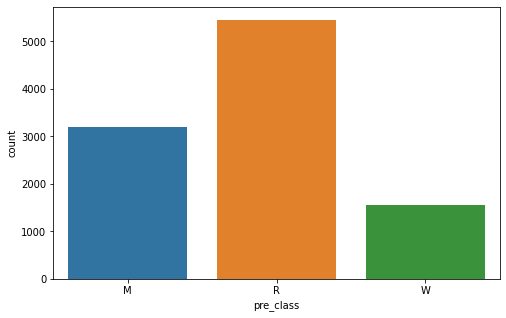

In [61]:
# 시각화

# plt.rcParams["figure.figsize"] = (6, 5)
sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 1)&(df['ladder'] == 'Harbinger')], order = ['M','R','W'])

### SSF Harbinger 

In [62]:
# SSF arbinger

df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger')].shape

(7853, 15)

In [63]:
# 이 모드에서 하나만 선택한 캐릭터들의 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger')].shape[0] / df[(df['ladder'] == 'SSF Harbinger')].shape[0] * 100

52.4197316601028

In [64]:
# 하나만 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger')]['pre_class'].value_counts() / df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger')].shape[0] * 100

M    40.659621
W    33.681396
R    25.658984
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

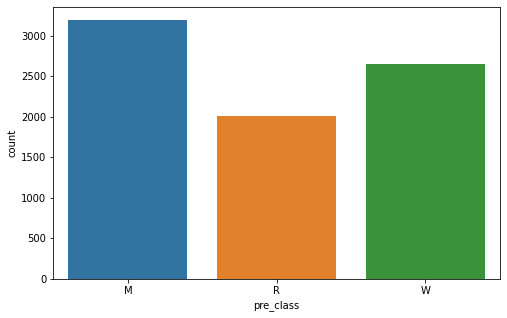

In [65]:
# 시각화

sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger')], order = ['M','R','W'])

### Hardcore Harbinger

In [66]:
# Hardcore Harbinger

df[(df['stats_num'] == 1)&(df['ladder'] == 'Hardcore Harbinger')].shape

(7469, 15)

In [67]:
# 이 모드에서 하나만 선택한 캐릭터들의 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'Hardcore Harbinger')].shape[0] / df[(df['ladder'] == 'Hardcore Harbinger')].shape[0] * 100

50.11070110701107

In [68]:
# 하나만 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'Hardcore Harbinger')]['pre_class'].value_counts() / df[(df['stats_num'] == 1)&(df['ladder'] == 'Hardcore Harbinger')].shape[0] * 100

M    45.882983
W    34.275003
R    19.842014
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

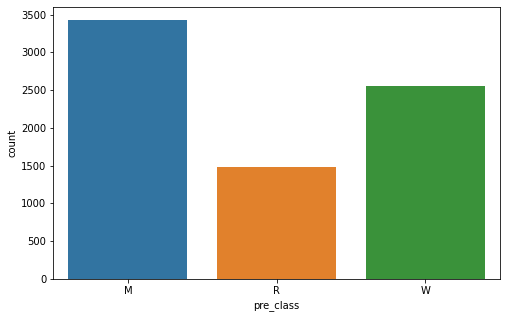

In [69]:
# 시각화

sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 1)&(df['ladder'] == 'Hardcore Harbinger')], order = ['M','R','W'])

### SSF Harbinger HC

In [70]:
# SSF Harbinger Hardcore

df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger HC')].shape

(7362, 15)

In [71]:
# 이 모드에서 하나만 선택한 캐릭터들의 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger HC')].shape[0] / df[(df['ladder'] == 'SSF Harbinger HC')].shape[0] * 100

49.171787336361206

In [72]:
# 하나만 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger HC')]['pre_class'].value_counts() / df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger HC')].shape[0] * 100

M    42.855202
W    40.722630
R    16.422168
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

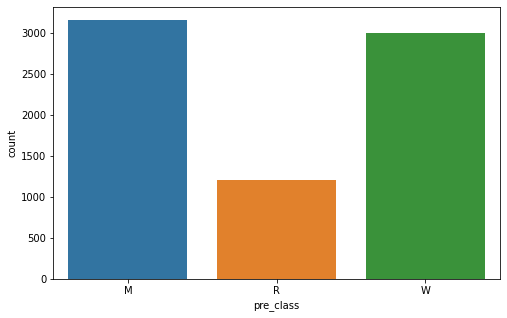

In [73]:
# 시각화

sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 1)&(df['ladder'] == 'SSF Harbinger HC')], order = ['M','R','W'])

## Comentary

> 한 가지를 찍은 사람은 적어도 반 정도는 되었고, 유독 Harbinger 모드에서 Ranger의 비율이 높았다.

> Harbinger HC에서와 SSF Harbinger에서는 Marauder의 비율이 높다가

> SSF Harbinger HC 모드에서는 Witch의 비율이 상당히 많이 올라온다.



# Two stats class and Three stat class
---

이번엔 두 스탯을 찍는 직업들을 비교해보고자 한다.

In [74]:
df[df['stats_num'] == 2].describe()

,rank,level,experience,challenges,special_class,stat_Str,stat_Int,stat_Dex,stats_num
count,23094.000000,23094.000000,2.309400e+04,23094.000000,23094.000000,23094.000000,23094.000000,23094.000000,23094.0
mean,7463.189530,84.301160,1.684212e+09,24.865723,0.992119,0.780722,0.494847,0.724431,2.0
std,4301.343291,11.320677,1.044201e+09,8.182547,0.088425,0.413766,0.499984,0.446810,0.0
min,1.000000,53.000000,7.793689e+07,5.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,3743.000000,77.000000,6.952929e+08,19.000000,1.000000,1.000000,0.000000,0.000000,2.0
50%,7481.000000,89.000000,1.816992e+09,24.000000,1.000000,1.000000,0.000000,1.000000,2.0
75%,11149.000000,93.000000,2.488489e+09,30.000000,1.000000,1.000000,1.000000,1.000000,2.0
max,14981.000000,100.000000,4.250334e+09,40.000000,1.000000,1.000000,1.000000,1.000000,2.0


In [75]:
# 전체 중 스탯 둘을 찍은 캐릭터들의 총 비율

df[(df['stats_num'] == 2)].shape[0] / df.shape[0] * 100

38.63423447537473

In [76]:
# 전체 중 스탯을 둘 찍은 캐릭터들의 직업별 비율

df[df['stats_num'] == 2]['pre_class'].value_counts() / df.shape[0] * 100

D    19.516194
T    10.646413
S     8.471627
Name: pre_class, dtype: float64

In [77]:
# 스탯 둘을 찍은 캐릭터들 사이에서의 비중

df[df['stats_num'] == 2]['pre_class'].value_counts() / df[df['stats_num'] == 2].shape[0] * 100

D    50.515285
T    27.556941
S    21.927773
Name: pre_class, dtype: float64

## two stat classes by ladder
> 그렇다면 게임 모드별로 이 수는 어떻게 변하는가?

### Harbinger 

In [78]:
# Harbinger

df[(df['stats_num'] == 2)&(df['ladder'] == 'Harbinger')].shape

(3986, 15)

In [79]:
# 이 모드에서 둘 스탯을 찍은 캐릭터들의 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'Harbinger')].shape[0] / df[(df['ladder'] == 'Harbinger')].shape[0] * 100

26.71939938329535

In [80]:
# 두개를 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'Harbinger')]['pre_class'].value_counts() / df[(df['stats_num'] == 2)&(df['ladder'] == 'Harbinger')].shape[0] * 100

D    62.217762
T    25.338685
S    12.443552
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

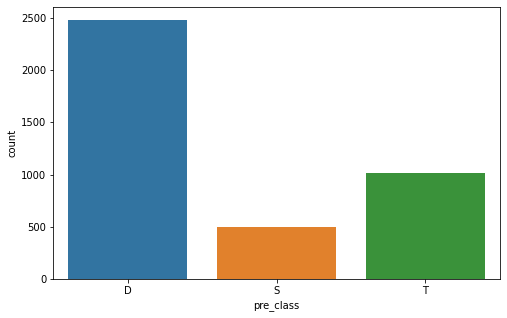

In [81]:
# 시각화

# plt.rcParams["figure.figsize"] = (6, 5)
sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 2)&(df['ladder'] == 'Harbinger')], order = ['D','S','T'])

### SSF Harbinger 

In [82]:
# SSF arbinger

df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger')].shape

(6120, 15)

In [83]:
# 이 모드에서 둘 스탯을 찍은 캐릭터들의 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger')].shape[0] / df[(df['ladder'] == 'SSF Harbinger')].shape[0] * 100

40.851745544356184

In [84]:
# 두개를 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger')]['pre_class'].value_counts() / df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger')].shape[0] * 100

D    47.271242
S    26.895425
T    25.833333
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

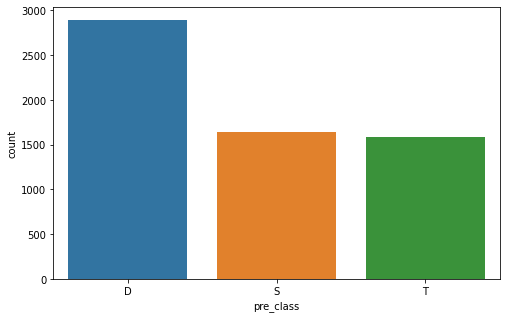

In [85]:
# 시각화

sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger')], order = ['D','S','T'])

### Hardcore Harbinger

In [86]:
# Hardcore Harbinger

df[(df['stats_num'] == 2)&(df['ladder'] == 'Hardcore Harbinger')].shape

(6286, 15)

In [87]:
# 이 모드에서 둘 스탯을 찍은 캐릭터들의 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'Hardcore Harbinger')].shape[0] / df[(df['ladder'] == 'Hardcore Harbinger')].shape[0] * 100

42.173767192217376

In [88]:
# 두개를 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'Hardcore Harbinger')]['pre_class'].value_counts() / df[(df['stats_num'] == 2)&(df['ladder'] == 'Hardcore Harbinger')].shape[0] * 100

D    50.731785
T    30.019090
S    19.249125
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

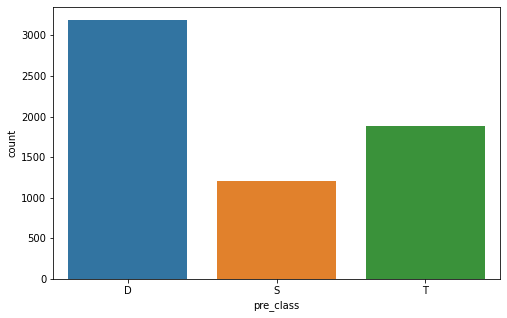

In [89]:
# 시각화

sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 2)&(df['ladder'] == 'Hardcore Harbinger')], order = ['D','S','T'])

### SSF Harbinger HC

In [90]:
# SSF Harbinger Hardcore

df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger HC')].shape

(6702, 15)

In [91]:
# 이 모드에서 둘 스탯을 찍은 캐릭터들의 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger HC')].shape[0] / df[(df['ladder'] == 'SSF Harbinger HC')].shape[0] * 100

44.76355864279989

In [92]:
# 두개를 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger HC')]['pre_class'].value_counts() / df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger HC')].shape[0] * 100

D    46.314533
T    28.140853
S    25.544614
Name: pre_class, dtype: float64

<AxesSubplot:xlabel='pre_class', ylabel='count'>

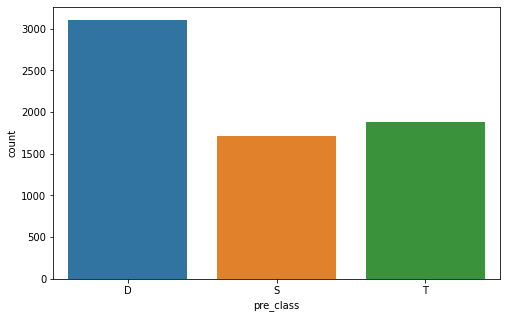

In [93]:
# 시각화

sns.countplot(x = 'pre_class', data = df[(df['stats_num'] == 2)&(df['ladder'] == 'SSF Harbinger HC')], order = ['D','S','T'])

### characters by ladder

In [147]:
pd.crosstab(index = df['stats_num'], columns = df['ladder'])

ladder,Harbinger,Hardcore Harbinger,SSF Harbinger,SSF Harbinger HC
stats_num,,,,
1,10192,7469,7853,7362
2,3986,6286,6120,6702
3,740,1150,1008,908


## Commentary

- 게임모드를 나누기 전, 스탯 둘을 찍은 캐릭터는 38% 정도이다. 

- 스탯을 하나만 찍은 직업군 자체에서 가장 많은 수는 힘과 민첩을 선택한 캐릭터들이다. 그들 중 Dualist를 선택한 캐릭터가 전체 두 스탯 캐릭터중 50%에 달한다.

- 아무래도 두 스탯을 찍은 사람들이 한 스탯을 찍은 캐릭터들보다 적기는 하지만, 특히 Harbinger 모드에서는 다른 모드에서보다 유독 적은(거의 60%에 미치는) 3986개의 캐릭터가 존재하고 있다. (바로 위의 표 참고)

- 


## Three stat class by ladder

In [94]:
# 3개를 찍은 캐릭터는 Sc를 찾아도 된다.

df[df['stats_num'] == 3].describe()

,rank,level,experience,challenges,special_class,stat_Str,stat_Int,stat_Dex,stats_num
count,3806.000000,3806.000000,3.806000e+03,3806.000000,3806.000000,3806.0,3806.0,3806.0,3806.0
mean,7578.089858,85.025749,1.765743e+09,25.988702,0.986337,1.0,1.0,1.0,3.0
std,4253.503566,11.190848,1.064200e+09,8.329207,0.116101,0.0,0.0,0.0,0.0
min,12.000000,53.000000,7.794179e+07,5.000000,0.000000,1.0,1.0,1.0,3.0
25%,3988.250000,78.000000,7.375787e+08,20.000000,1.000000,1.0,1.0,1.0,3.0
50%,7707.500000,89.000000,1.905394e+09,25.000000,1.000000,1.0,1.0,1.0,3.0
75%,11138.000000,94.000000,2.680416e+09,33.000000,1.000000,1.0,1.0,1.0,3.0
max,14973.000000,100.000000,4.250334e+09,40.000000,1.000000,1.0,1.0,1.0,3.0


In [95]:
# 전체 중 스탯 셋을 찍은, Scion인 캐릭터들의 총 비율

df[(df['stats_num'] == 3)].shape[0] / df.shape[0] * 100

6.367103854389722

Scion의 경우 Scion과 전직 후 Ascendant 이렇게만 두 직업이 있으므로 간단하게 통계량만 보도록 한다.

In [96]:
# 전체 중 스탯 전부 찍은 캐릭터들의 직업별 비율

df[df['stats_num'] == 3]['class'].value_counts() / df.shape[0] * 100

Ascendant    6.280112
Scion        0.086991
Name: class, dtype: float64

In [98]:
# 스탯을 전부 찍은 캐릭터들 사이에서의 비중

df[df['stats_num'] == 3]['class'].value_counts() / df[df['stats_num'] == 3].shape[0] * 100

Ascendant    98.633736
Scion         1.366264
Name: class, dtype: float64

## Three stat classes by ladder
> 그렇다면 게임 모드별로 Scion의 수는 어떻게 변하는가?

### Harbinger 

In [99]:
# Harbinger

df[(df['stats_num'] == 3)&(df['ladder'] == 'Harbinger')].shape

(740, 15)

In [100]:
# 이 모드에서 스탯 세개를 찍은 캐릭터들의 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'Harbinger')].shape[0] / df[(df['ladder'] == 'Harbinger')].shape[0] * 100

4.960450462528489

In [101]:
# 세 스탯을 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'Harbinger')]['class'].value_counts() / df[(df['stats_num'] == 3)&(df['ladder'] == 'Harbinger')].shape[0] * 100

Ascendant    100.0
Name: class, dtype: float64

### SSF Harbinger 

In [103]:
# SSF arbinger

df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger')].shape

(1008, 15)

In [104]:
# 이 모드에서 스탯 셋을 찍은 캐릭터들의 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger')].shape[0] / df[(df['ladder'] == 'SSF Harbinger')].shape[0] * 100

6.728522795541019

In [105]:
# 세 스탯을 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger')]['class'].value_counts() / df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger')].shape[0] * 100

Ascendant    99.206349
Scion         0.793651
Name: class, dtype: float64

### Hardcore Harbinger

In [106]:
# Hardcore Harbinger

df[(df['stats_num'] == 3)&(df['ladder'] == 'Hardcore Harbinger')].shape

(1150, 15)

In [107]:
# 이 모드에서 스탯 셋을 찍은 캐릭터들의 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'Hardcore Harbinger')].shape[0] / df[(df['ladder'] == 'Hardcore Harbinger')].shape[0] * 100

7.715531700771554

In [111]:
# 세 스탯을 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'Hardcore Harbinger')]['class'].value_counts() / df[(df['stats_num'] == 3)&(df['ladder'] == 'Hardcore Harbinger')].shape[0] * 100

Ascendant    99.913043
Scion         0.086957
Name: class, dtype: float64

### SSF Harbinger HC

In [112]:
# SSF Harbinger Hardcore

df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger HC')].shape

(908, 15)

In [113]:
# 이 모드에서 스탯 셋을 찍은 캐릭터들의 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger HC')].shape[0] / df[(df['ladder'] == 'SSF Harbinger HC')].shape[0] * 100

6.0646540208388995

In [114]:
# 세 스탯을 선택한 캐릭터들 중 직업별 비율

df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger HC')]['class'].value_counts() / df[(df['stats_num'] == 3)&(df['ladder'] == 'SSF Harbinger HC')].shape[0] * 100

Ascendant    95.264317
Scion         4.735683
Name: class, dtype: float64

## Scions(Three stat classes) number by ladder

<AxesSubplot:xlabel='ladder', ylabel='count'>

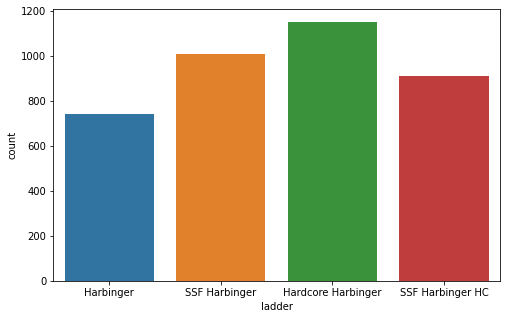

In [115]:
# 시각화

sns.countplot(x = 'ladder', data = df[(df['stats_num'] == 3)], order = ['Harbinger','SSF Harbinger', 'Hardcore Harbinger','SSF Harbinger HC'])

## Comentary

Scion은 수가 적고, 눈에 띄는 무언가를 보여주지는 않았다. Hardcore Harbinger 모드에서 좀 더 선호되었다는 정도이다.

# Classes number by ladder

지금까지는 클래스에 따라 선호되는 클래스가 어떤 직업군일지 스탯의 개수에 따라보았다.

지금부터는 관점을 바꾸어서 해당 클래스가 모드를 선택한다는 관점에서 한 클래스별로 모드별로 변화하는 양을 보고자 한다. 

한 클래스를 하더라도 모드에 따라 선호되는게 다를 수 있다.

ladder에 따라, 클래스별로 다른 수들을 시각화해본다.